In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import pickle

# Path to the CIFAR-10 dataset directory
cifar10_dir = 'cifar-10-python/cifar-10-batches-py'  # Replace this with the actual path

# Function to load the CIFAR-10 dataset from the Python version
def load_cifar10_data(cifar10_dir):
    # Load label names from batches.meta
    with open(os.path.join(cifar10_dir, 'batches.meta'), 'rb') as f:
        meta = pickle.load(f, encoding='latin1')
    label_names = meta['label_names']

    # Load training data (there are 5 batches)
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(cifar10_dir, f'data_batch_{i}')
        with open(batch_file, 'rb') as f:
            batch = pickle.load(f, encoding='latin1')
            train_images.append(batch['data'])
            train_labels.append(batch['labels'])
    
    # Combine all the training batches
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Load test data
    test_batch_file = os.path.join(cifar10_dir, 'test_batch')
    with open(test_batch_file, 'rb') as f:
        test_batch = pickle.load(f, encoding='latin1')
        test_images = test_batch['data']
        test_labels = np.array(test_batch['labels'])
    
    # Reshape the images to 32x32x3 and normalize them
    train_images = train_images.reshape(-1, 32, 32, 3) / 255.0
    test_images = test_images.reshape(-1, 32, 32, 3) / 255.0
    
    # One-hot encode labels
    train_labels = tf.keras.utils.to_categorical(train_labels, 10)
    test_labels = tf.keras.utils.to_categorical(test_labels, 10)
    
    return (train_images, train_labels), (test_images, test_labels), label_names

# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels), label_names = load_cifar10_data(cifar10_dir)

# Create TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((train_images, (train_images, train_labels)))
test_data = tf.data.Dataset.from_tensor_slices((test_images, (test_images, test_labels)))

# Preprocess the data
train_data = train_data.batch(128).shuffle(10000)
test_data = test_data.batch(128)

# Encoder
encoder = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
])

# Decoder
decoder = models.Sequential([
    layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same'),
])

# Classifier
classifier = models.Sequential([
    layers.Flatten(),
    layers.Dense(2048, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Input
input_img = layers.Input(shape=(32, 32, 3))
latent = encoder(input_img)
reconstructed = decoder(latent)
classified = classifier(latent)

# Model with named outputs
model = models.Model(inputs=input_img, outputs=[reconstructed, classified])

# Explicitly name the outputs in the model definition
model.output_names = ['reconstructed', 'classifier']

# Loss function and optimizer
def custom_loss(y_true, y_pred):
    recon_loss = tf.keras.losses.MSE(y_true[0], y_pred[0])
    class_loss = tf.keras.losses.CategoricalCrossentropy()(y_true[1], y_pred[1])
    return recon_loss + class_loss

model.compile(optimizer='adam', loss=["mse", "categorical_crossentropy"], metrics={"classifier": "accuracy"})

# Train the model
model.fit(train_data, validation_data=test_data, epochs=10)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - classifier_accuracy: 0.3098 - classifier_loss: 1.8661 - loss: 1.9127 - reconstructed_loss: 0.0465 - val_classifier_accuracy: 0.5127 - val_classifier_loss: 1.3464 - val_loss: 1.3755 - val_reconstructed_loss: 0.0277
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - classifier_accuracy: 0.5341 - classifier_loss: 1.3124 - loss: 1.3397 - reconstructed_loss: 0.0274 - val_classifier_accuracy: 0.5666 - val_classifier_loss: 1.2190 - val_loss: 1.2448 - val_reconstructed_loss: 0.0258
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - classifier_accuracy: 0.6038 - classifier_loss: 1.1274 - loss: 1.1532 - reconstructed_loss: 0.0257 - val_classifier_accuracy: 0.6018 - val_classifier_loss: 1.1135 - val_loss: 1.1422 - val_reconstructed_loss: 0.0262
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - classifier_accuracy: 0.6488 - classifier_loss: 0.9969 - loss: 1.0220 - reconstructed_loss: 0.0251 - val_classifier_accuracy: 0.6016 - 

## test it

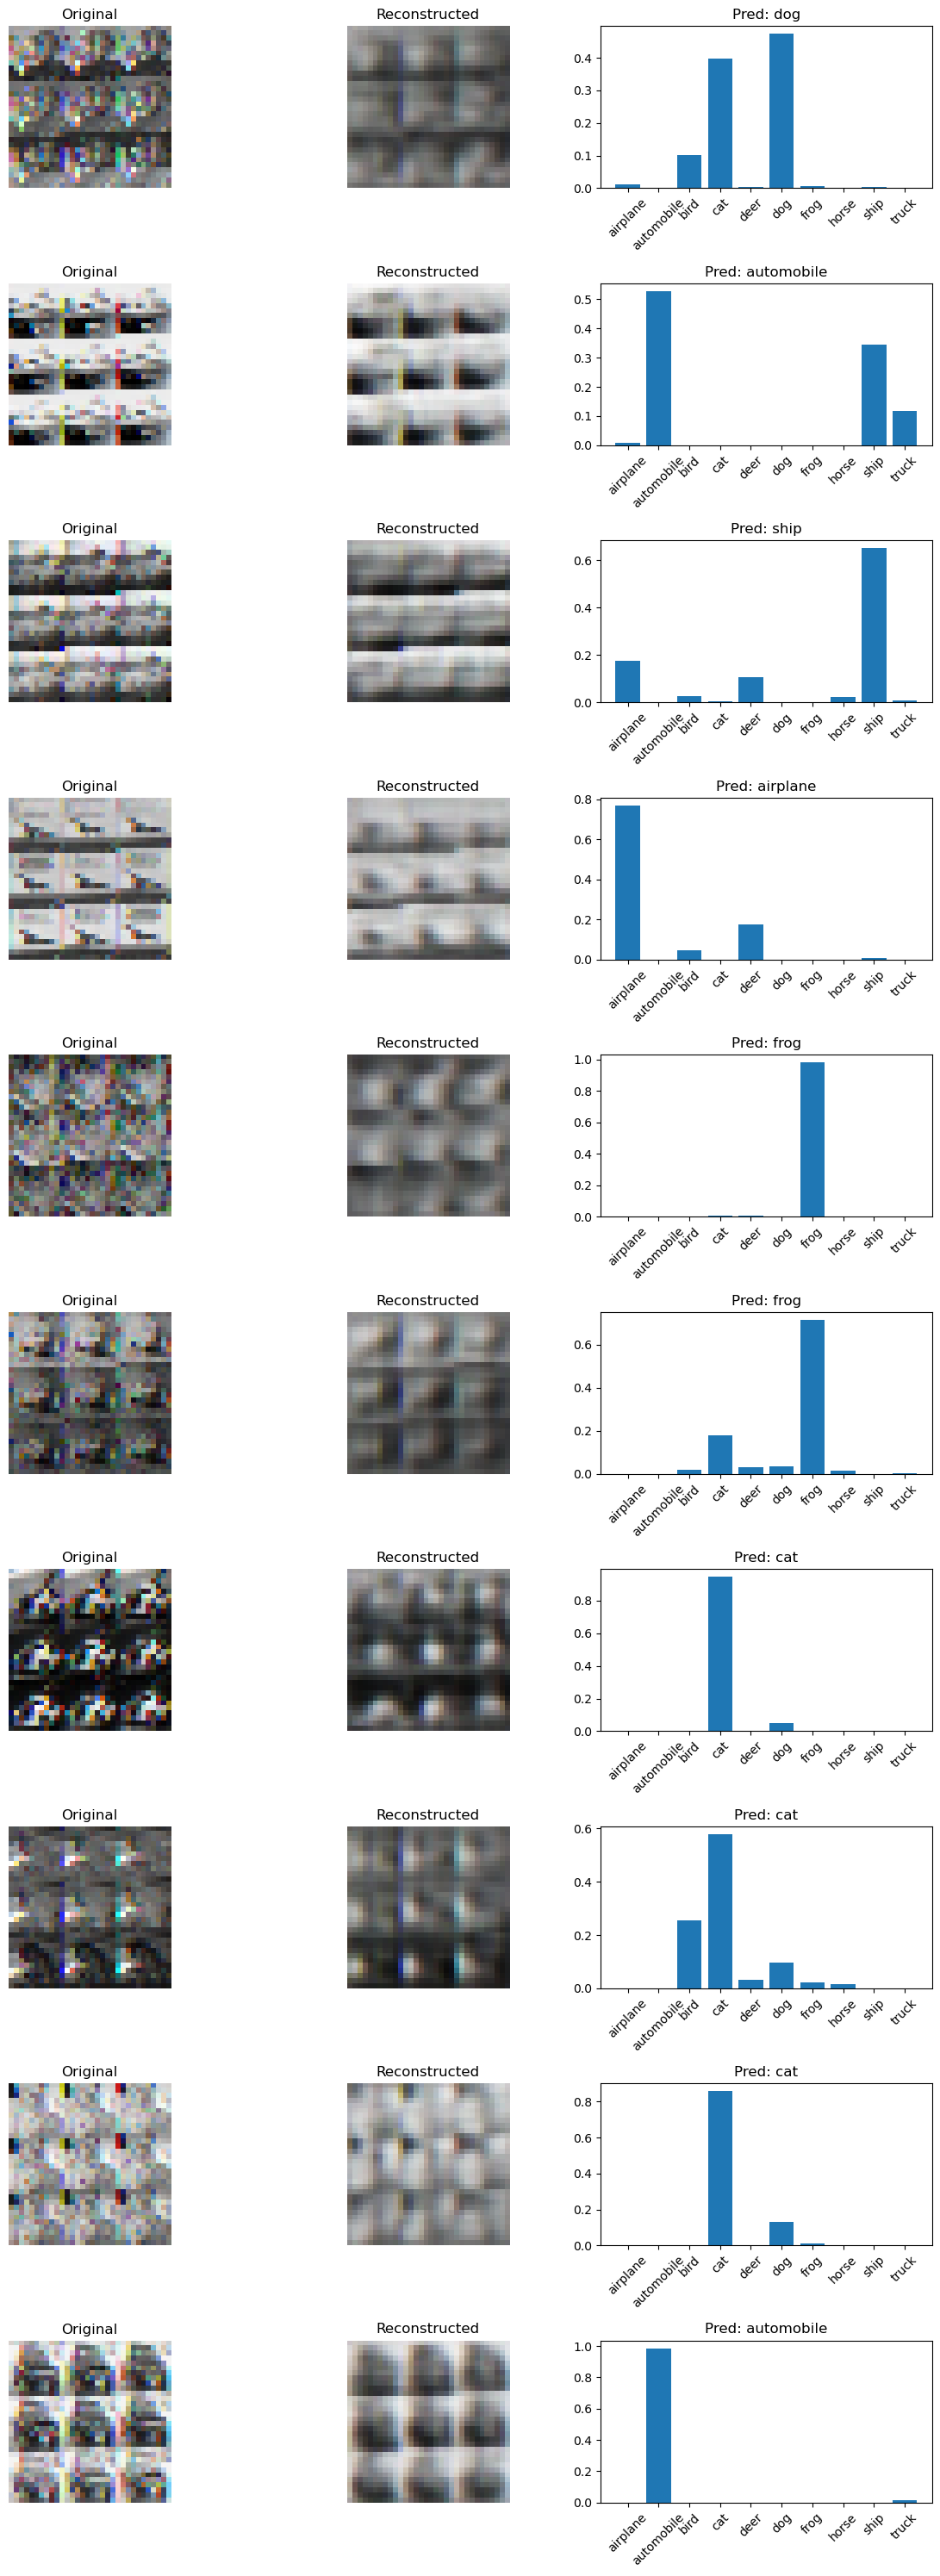

In [16]:
# Number of images to visualize (use the minimum between 10 and available images)
num_images_to_visualize = min(10, test_images_subset.shape[0])

# Plot the results
fig, axes = plt.subplots(num_images_to_visualize, 3, figsize=(12, num_images_to_visualize * 3))
axes = axes.flatten()

# Display original image, reconstructed image, and predicted class
for i in range(num_images_to_visualize):
    # Original image
    axes[i * 3].imshow(test_images_subset[i])
    axes[i * 3].set_title(f"Original")
    axes[i * 3].axis('off')

    # Reconstructed image
    axes[i * 3 + 1].imshow(reconstructed_images[i])
    axes[i * 3 + 1].set_title(f"Reconstructed")
    axes[i * 3 + 1].axis('off')

    # Predicted class
    axes[i * 3 + 2].bar(np.arange(10), predicted_classes[i])
    predicted_class = np.argmax(predicted_classes[i])
    axes[i * 3 + 2].set_title(f"Pred: {label_names[predicted_class]}")
    axes[i * 3 + 2].set_xticks(np.arange(10))
    axes[i * 3 + 2].set_xticklabels(label_names, rotation=45)

plt.tight_layout()
plt.show()


## show the original images 

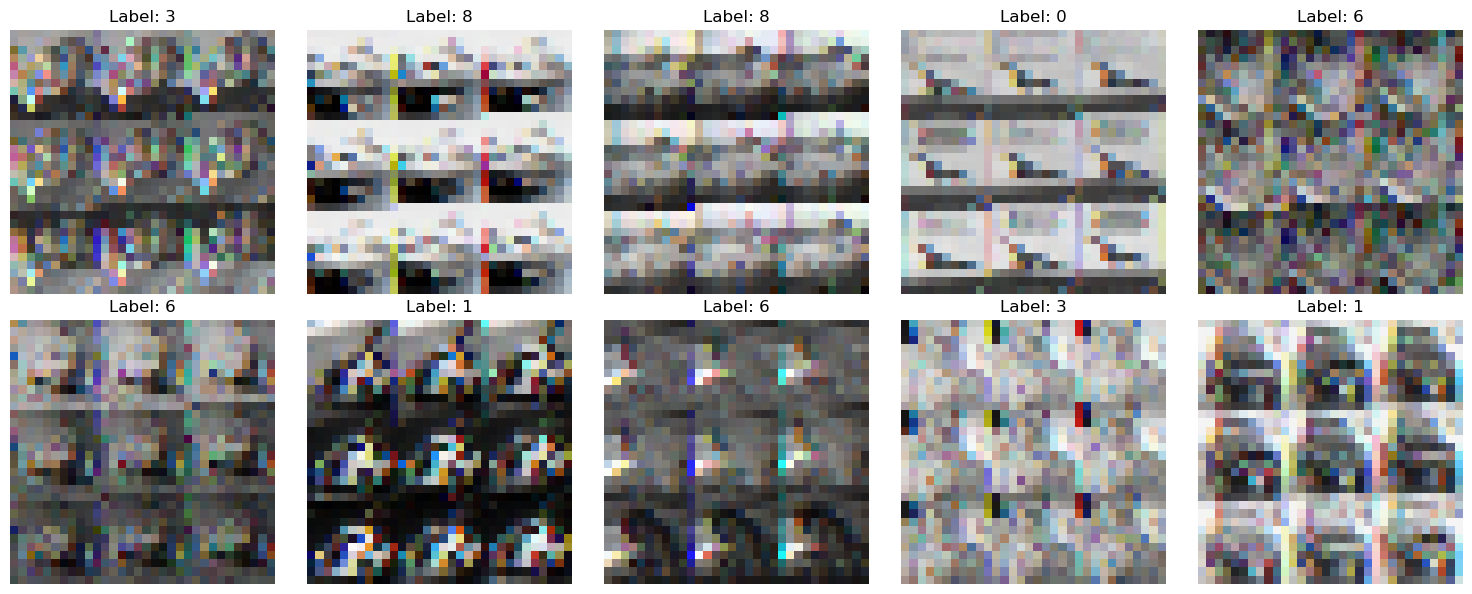

In [21]:
import matplotlib.pyplot as plt

# Get the first 10 test images
num_images_to_visualize = 10
test_images_subset = test_images[:num_images_to_visualize]
test_labels_subset = test_labels[:num_images_to_visualize]

# Create a grid of subplots to display the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()

# Plot the first 10 test images
for i in range(num_images_to_visualize):
    axes[i].imshow(test_images_subset[i])
    axes[i].set_title(f"Label: {np.argmax(test_labels_subset[i])}")  # Display label
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## when i load the image, some place went wrong, current imaghe is very blur

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import pickle

# Path to the CIFAR-10 dataset directory
cifar10_dir = 'cifar-10-python/cifar-10-batches-py'  # Replace this with the actual path

# Function to load the CIFAR-10 dataset from the Python version
def load_cifar10_data(cifar10_dir):
    # Load label names from batches.meta
    with open(os.path.join(cifar10_dir, 'batches.meta'), 'rb') as f:
        meta = pickle.load(f, encoding='latin1')
    label_names = meta['label_names']

    # Load training data (there are 5 batches)
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(cifar10_dir, f'data_batch_{i}')
        with open(batch_file, 'rb') as f:
            batch = pickle.load(f, encoding='latin1')
            train_images.append(batch['data'])
            train_labels.append(batch['labels'])
    
    # Combine all the training batches
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Load test data
    test_batch_file = os.path.join(cifar10_dir, 'test_batch')
    with open(test_batch_file, 'rb') as f:
        test_batch = pickle.load(f, encoding='latin1')
        test_images = test_batch['data']
        test_labels = np.array(test_batch['labels'])
    
    # Reshape the images to 32x32x3 and normalize them
    train_images = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0  # 关键修改
    test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0    # 关键修改
    
    # One-hot encode labels
    train_labels = tf.keras.utils.to_categorical(train_labels, 10)
    test_labels = tf.keras.utils.to_categorical(test_labels, 10)
    
    return (train_images, train_labels), (test_images, test_labels), label_names

# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels), label_names = load_cifar10_data(cifar10_dir)

# Create TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((train_images, (train_images, train_labels)))
test_data = tf.data.Dataset.from_tensor_slices((test_images, (test_images, test_labels)))

# Preprocess the data
train_data = train_data.batch(128).shuffle(10000)
test_data = test_data.batch(128)



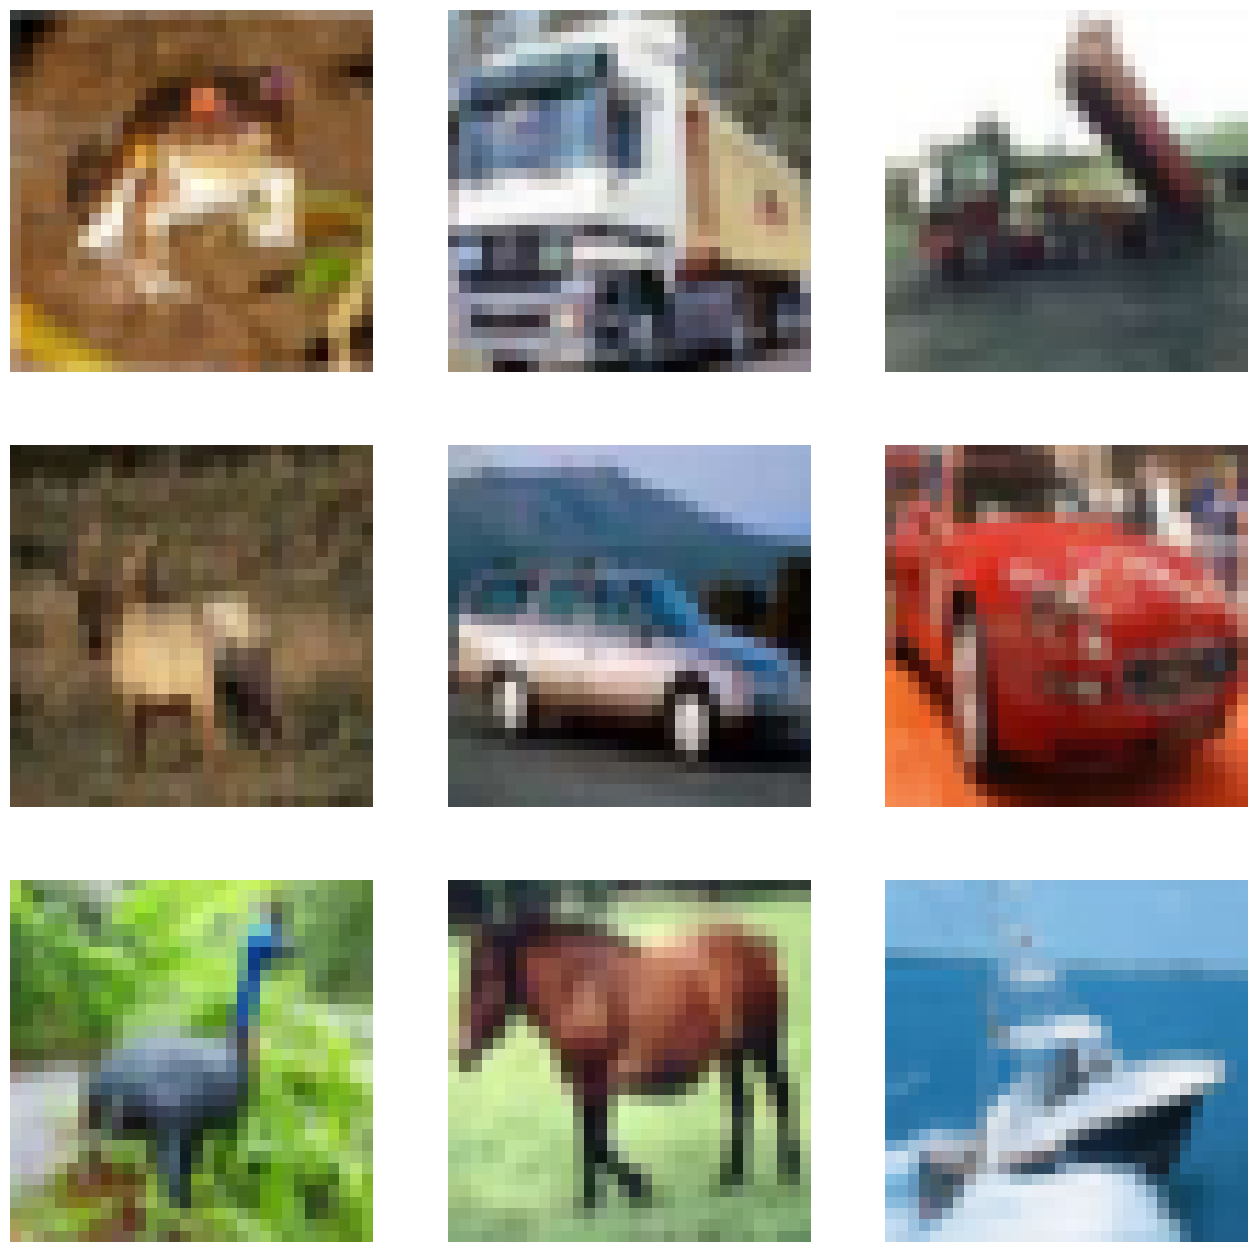

In [28]:
import matplotlib.pyplot as plt

# 显示修改后的图像
plt.figure(figsize=(16,16))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i])
    plt.axis('off')
plt.show()

In [30]:
# Encoder
encoder = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
])

# Decoder
decoder = models.Sequential([
    layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same'),
])

# Classifier
classifier = models.Sequential([
    layers.Flatten(),
    layers.Dense(2048, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Input
input_img = layers.Input(shape=(32, 32, 3))
latent = encoder(input_img)
reconstructed = decoder(latent)
classified = classifier(latent)

# Model with named outputs
model = models.Model(inputs=input_img, outputs=[reconstructed, classified])

# Explicitly name the outputs in the model definition
model.output_names = ['reconstructed', 'classifier']

# Loss function and optimizer
def custom_loss(y_true, y_pred):
    recon_loss = tf.keras.losses.MSE(y_true[0], y_pred[0])
    class_loss = tf.keras.losses.CategoricalCrossentropy()(y_true[1], y_pred[1])
    return recon_loss + class_loss

model.compile(optimizer='adam', loss=["mse", "categorical_crossentropy"], metrics={"classifier": "accuracy"})

# Train the model
model.fit(train_data, validation_data=test_data, epochs=10)


Epoch 1/10


C:\Users\12905\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - classifier_accuracy: 0.3550 - classifier_loss: 1.7533 - loss: 1.7874 - reconstructed_loss: 0.0341 - val_classifier_accuracy: 0.5830 - val_classifier_loss: 1.1712 - val_loss: 1.1837 - val_reconstructed_loss: 0.0154
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - classifier_accuracy: 0.6185 - classifier_loss: 1.0700 - loss: 1.0857 - reconstructed_loss: 0.0157 - val_classifier_accuracy: 0.6709 - val_classifier_loss: 0.9234 - val_loss: 0.9371 - val_reconstructed_loss: 0.0147
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - classifier_accuracy: 0.7096 - classifier_loss: 0.8316 - loss: 0.8467 - reconstructed_loss: 0.0152 - val_classifier_accuracy: 0.7008 - val_classifier_loss: 0.8649 - val_loss: 0.8803 - val_reconstructed_loss: 0.0154
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - classifier_accuracy: 0.7591 - classifier_loss: 0.6856 - loss: 0.7008 - reconstructed_loss: 0.0153 - val_classifier_accuracy: 0.7296 - val_classif

## show the result

C:\Users\12905\AppData\Local\Temp\ipykernel_4432\1042659905.py:27: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


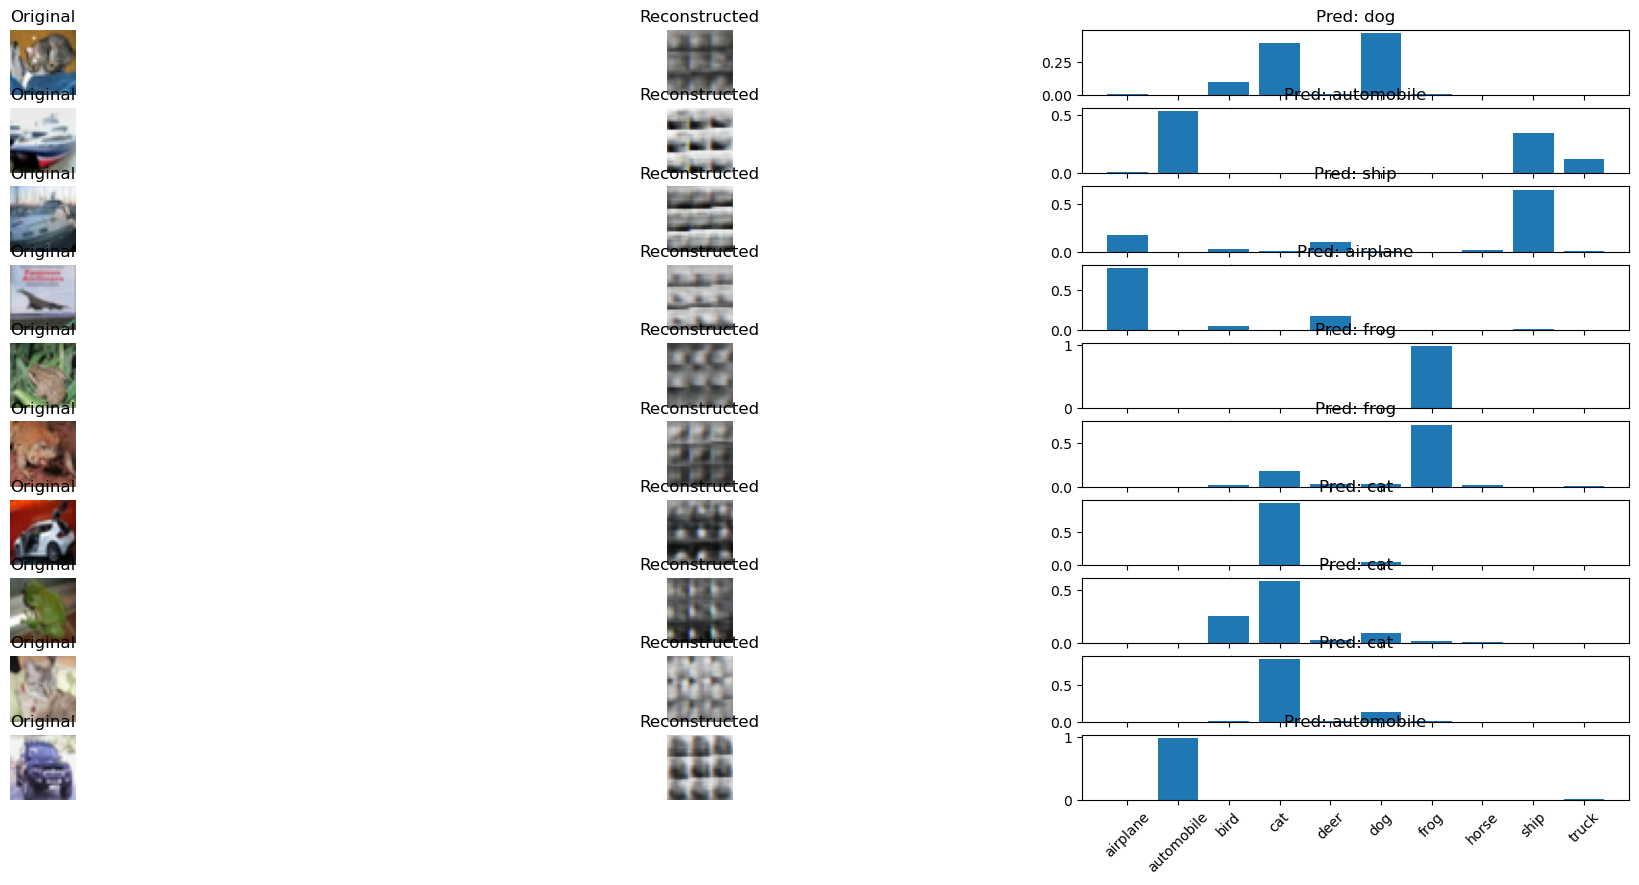

In [43]:
# Number of images to visualize (use the minimum between 10 and available images)
num_images_to_visualize = min(10, test_images_subset.shape[0])

# Plot the results
fig, axes = plt.subplots(num_images_to_visualize, 3, figsize=(24, num_images_to_visualize))
axes = axes.flatten()

# Display original image, reconstructed image, and predicted class
for i in range(num_images_to_visualize):
    # Original image
    axes[i * ].imshow(test_images_subset[i])
    axes[i ].set_title(f"Original")
    axes[i * 3].axis('off')

    # Reconstructed image
    axes[i * 3 + 1].imshow(reconstructed_images[i])
    axes[i * 3 + 1].set_title(f"Reconstructed")
    axes[i * 3 + 1].axis('off')

    # Predicted class
    axes[i * 3 + 2].bar(np.arange(10), predicted_classes[i])
    predicted_class = np.argmax(predicted_classes[i])
    axes[i * 3 + 2].set_title(f"Pred: {label_names[predicted_class]}")
    axes[i * 3 + 2].set_xticks(np.arange(10))
    axes[i * 3 + 2].set_xticklabels(label_names, rotation=45)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


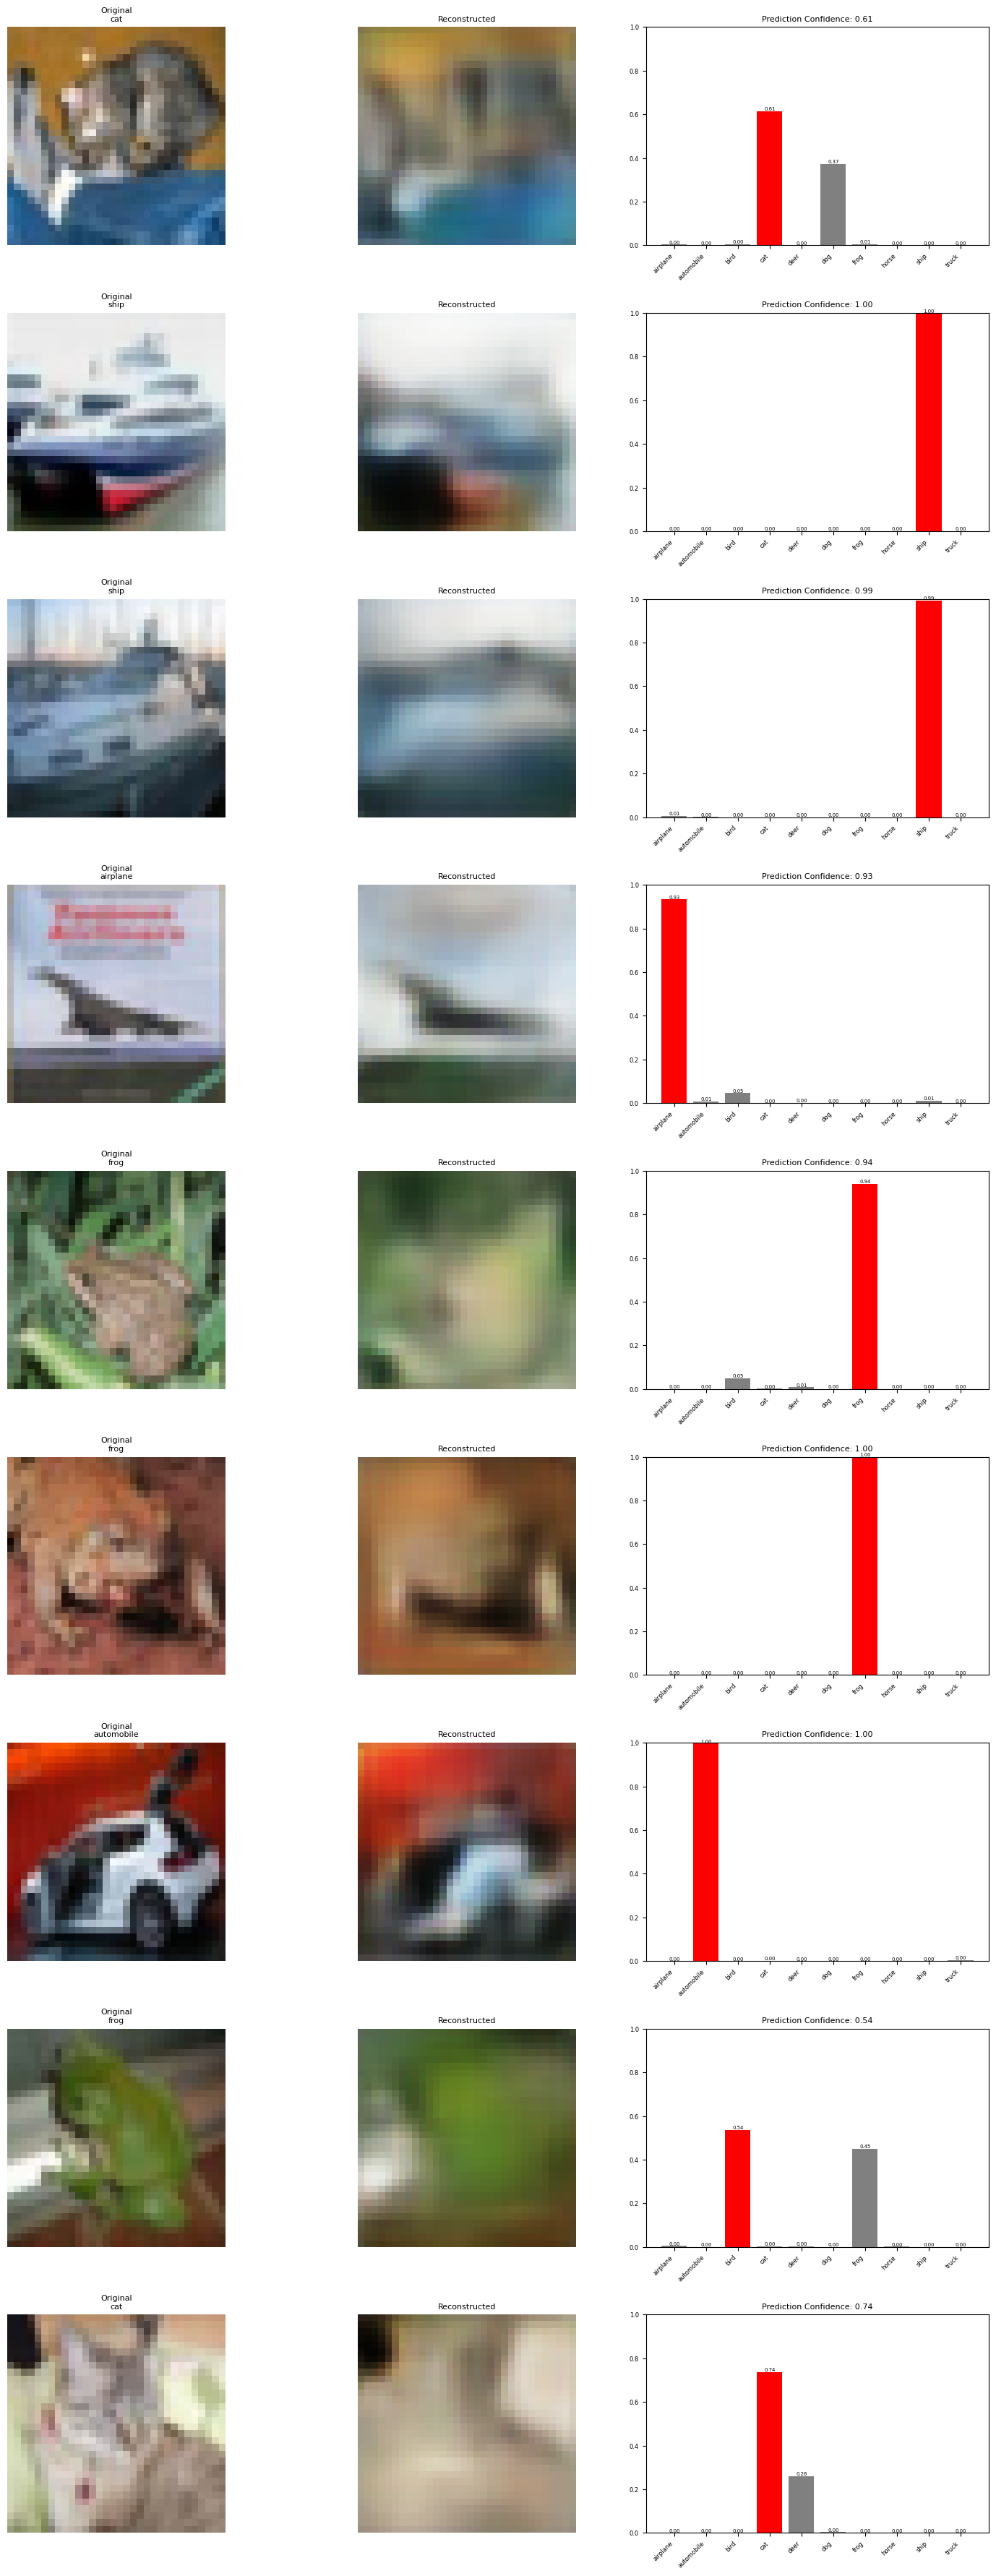

In [45]:
# 改进后的可视化代码
def visualize_results(test_images, reconstructed_images, predicted_probs, label_names, num_samples=9):
    plt.figure(figsize=(15, num_samples * 4))  # 动态调整高度
    
    for i in range(num_samples):
        # 确保不超过可用样本数
        if i >= len(test_images):
            break
            
        # 原始图像 ------------------------------------------------------------------
        plt.subplot(num_samples, 3, i*3 + 1)
        img = test_images[i]
        # 确保像素值在[0,1]范围内
        if img.max() > 1.0:
            img = img.astype(np.float32) / 255.0
        plt.imshow(img)
        plt.title(f"Original\n{label_names[np.argmax(test_labels[i])]}", fontsize=8)
        plt.axis('off')
        
        # 重建图像 ------------------------------------------------------------------
        plt.subplot(num_samples, 3, i*3 + 2)
        recon = reconstructed_images[i]
        # 处理可能存在的批量维度
        if len(recon.shape) == 4:
            recon = recon[0]
        # 确保数值范围正确
        recon = np.clip(recon, 0., 1.)
        plt.imshow(recon)
        plt.title("Reconstructed", fontsize=8)
        plt.axis('off')
        
        # 类别预测分布 -------------------------------------------------------------
        plt.subplot(num_samples, 3, i*3 + 3)
        probs = predicted_probs[i]
        # 处理批量维度
        if len(probs.shape) > 1:
            probs = probs[0]
            
        colors = ['gray'] * 10
        colors[np.argmax(probs)] = 'red'  # 高亮最高概率类别
        
        bars = plt.bar(range(10), probs, color=colors)
        plt.ylim(0, 1)
        plt.xticks(range(10), label_names, rotation=45, ha='right', fontsize=6)
        plt.yticks(fontsize=6)
        plt.title(f"Prediction Confidence: {np.max(probs):.2f}", fontsize=8)
        
        # 添加数值标签
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center', va='bottom',
                     fontsize=5)
    
    plt.tight_layout(pad=2.0)  # 增加布局间距
    plt.show()

# 使用示例 ----------------------------------------------------------------
# 获取预测结果（假设model是已训练好的模型）
test_samples = test_images[:9]  # 取前9个样本
reconstructed, predictions = model.predict(test_samples)

# 执行可视化
visualize_results(
    test_images=test_samples,
    reconstructed_images=reconstructed,
    predicted_probs=predictions,
    label_names=label_names,
    num_samples=9
)

## show the original

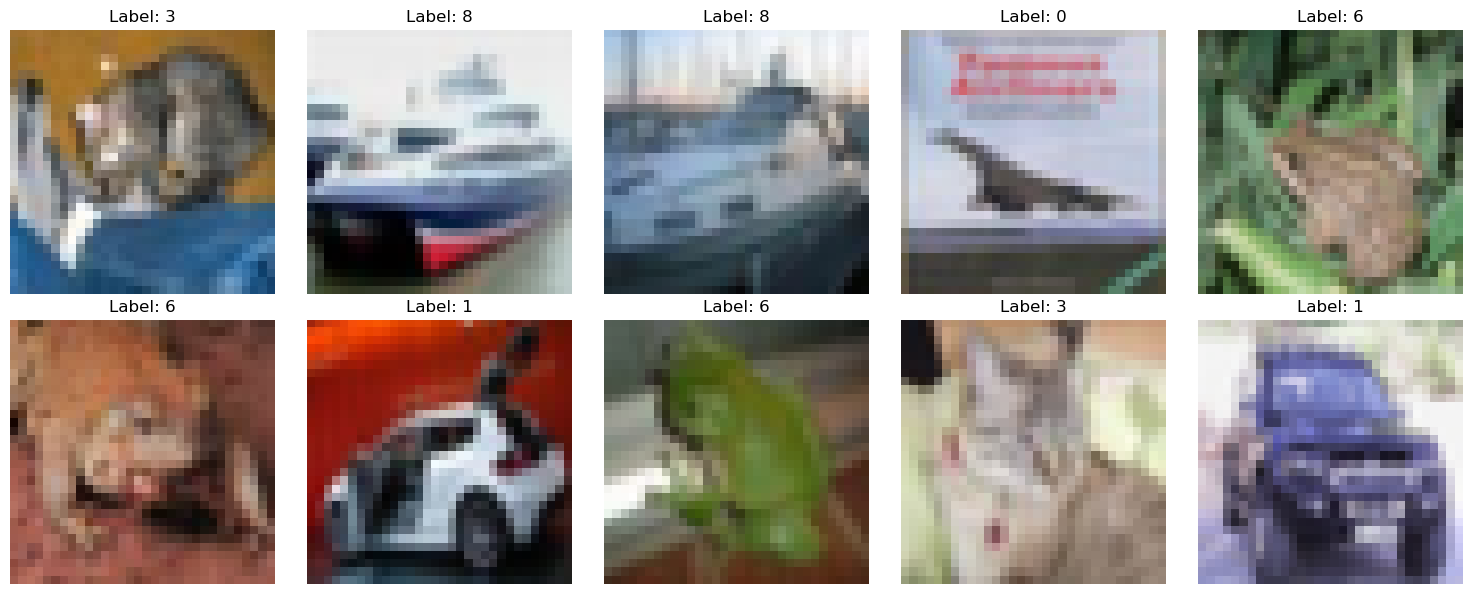

In [37]:
import matplotlib.pyplot as plt

# Get the first 10 test images
num_images_to_visualize = 10
test_images_subset = test_images[:num_images_to_visualize]
test_labels_subset = test_labels[:num_images_to_visualize]

# Create a grid of subplots to display the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()

# Plot the first 10 test images
for i in range(num_images_to_visualize):
    axes[i].imshow(test_images_subset[i])
    axes[i].set_title(f"Label: {np.argmax(test_labels_subset[i])}")  # Display label
    axes[i].axis('off')

plt.tight_layout()
plt.show()